<font color=orange>**Python Hackathon December 2023**</center></font>

<div class="alert alert-block alert-success">
<b><p><h1><center>Team 8 : Python Pioneers </center></h1> </p></b> 
</div>

<div class="alert alert-block alert-info">
<b><h3><center>Exam Stress Analysis</center></h3></b> 
</div>

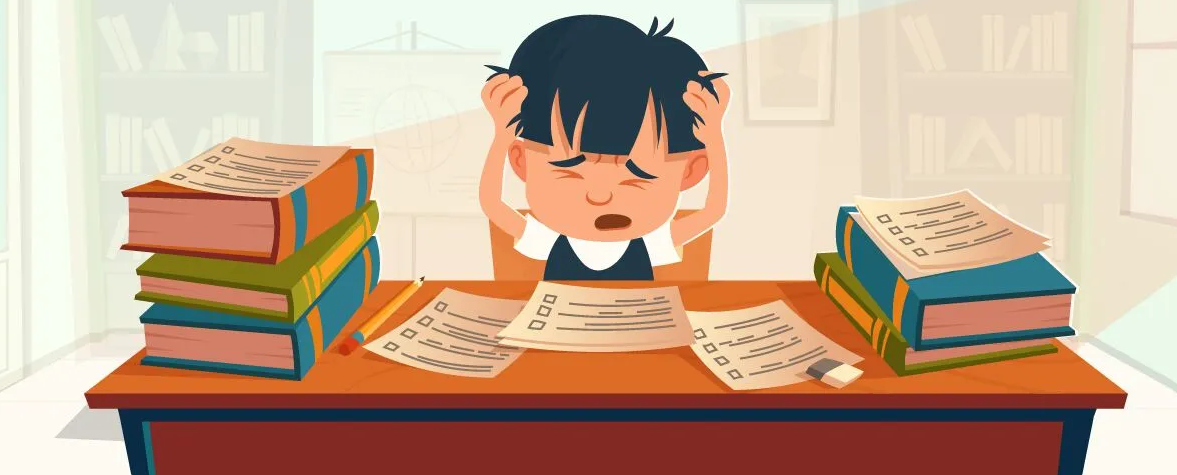

**<h3>Table of Content</h3>**
- [x] Introduction Exam Stress Analysis Dataset
- [x] Importing Data and Libraries
- [x] Hackathon Problem Statements (1-80)
- [x] Reference

# Introduction Exam Stress Analysis Dataset

The data contains electrodermal activity, heart rate, blood volume pulse, skin surface temperature, inter beat interval and accelerometer data recorded during three exam sessions (midterm 1, midterm 2 and final) as well as their corresponding grades. 

- <h3><p>Data Description</h3></P>

     *  Demographics  : Includes all patient details, masked for privacy
     *  IBI(Inter Beat Interval)  : Records the number of milliseconds that have passed between one heart beat and the next. The device records at 10 millisecond intervals sampled at the rate of 4 per minute.This dataset has been aggregated to 1 minute each.
     *  RMSSD  : Root mean square of Successive Standard Deviations from mean IBI.Must be calculated as 30 successive minutes of IBI averaged by student per exam
     *  HRV(Heart rate variability)  :Not the same as variation around a mean. HRV is the abiilty of the heart to respond to changes in blood flow demands within one beat. Since RMSSD is calculated for 30 minutes, Final Exams are 3 hours and Mid-terms are 1.5 hours. 600ms * RMSSD must be adjusted for this difference. 
     *  Time In Minutes  : Time elapsed from the start of the exam.The original unix timestamp has been converted to a simple minute ID to help you see how many minutes have elapsed from the start of each exam
     *  EDA(Electro Dermal activity)  : Electric signals that show nervous system activity. For the purpose of this hackathon, you can assume that higher actiivity indicates higher levels of stress
     *  HR(Heart rate)  : Averaged to number of beats for the corresponding minute
     *  Temp  : Basal Body temperature.Averaged to body temp for the corresponding minute


# Importing Data and Libraries

<h4>Python Libraries used for our Anlayis</h4>

In [129]:
# pip install panda
# pip install matplotlib
# pip install numpy
# pip install seaborn
# pip install colorama
# pip install wordcloud
# pip install plotly

In [2]:
import pandas as pd
import numpy as np
import random as random
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

<h4>Importing Exam Stress Dataset</h4>

In [4]:
df_Grades = pd.read_excel("Exam Stress Final.xlsx")
df_Demography =pd.read_excel("Exam Stress Final.xlsx",sheet_name="Demography")
df_EDA =pd.read_excel("Exam Stress Final.xlsx",sheet_name="EDA")
df_HR =pd.read_excel("Exam Stress Final.xlsx",sheet_name="HR")
df_Temp =pd.read_excel("Exam Stress Final.xlsx",sheet_name="Temp")
df_IBI=pd.read_excel("Exam Stress Final.xlsx",sheet_name="IBI")

# Hackathon Problem Statements (1-80)

<div class="alert alert-block alert-warning">
<b>Q1 :</b>Using the mean interbeat interval per minute, calculate the Root Mean Square of successive differences for any 30 minute interval and add this to IBI
</div>

In [45]:
def calculate_diff(ibi_values):
    return np.diff(ibi_values)

def square_diff(differences):
    return np.square(differences)

def calculate_mean_squared_diff(squared_diff):
    return np.mean(squared_diff)


def calculate_rmssd(mean_squared_diff):
    return np.sqrt(mean_squared_diff)


def calculate_rmssd_from_ibi(ibi_values):
    differences = calculate_diff(ibi_values)
    squared_diff = square_diff(differences)
    mean_squared_diff = calculate_mean_squared_diff(squared_diff)
    rmssd = calculate_rmssd(mean_squared_diff)
    return rmssd


# Load the DataFrame from Excel file
df_IBI_rmssd = pd.read_excel("Exam Stress Final.xlsx", sheet_name="IBI")

# Define the bin size for grouping (e.g., 30 minutes)
bin_size = 30

# Create bins using pd.cut
df_IBI_rmssd['bin(30 min Interval)'] = pd.cut(df_IBI_rmssd['Time in mins'], bins=range(0, df_IBI_rmssd['Time in mins'].max() + bin_size, bin_size), right=False)

# Group by the 'bin' column and calculate the mean for each group

#grouped_data = df_IBI_rmssd.groupby(['bin(30 min Interval)','Student_id', 'Exam']).mean()
grouped_data = df_IBI_rmssd.groupby(['bin(30 min Interval)']).mean().reset_index()

# Fill missing values in the DataFrame 'grouped_data'.
# The method 'fillna()' is used to handle NaN (Not a Number) values.
# Use the 'bfill' (backward fill) method to replace NaN values.

grouped_data = grouped_data.fillna(method='bfill')


# Calculating RMSSD for the 30-minute interval
ibi_values= grouped_data['IBI'] 

# Calculate RMSSD
rmssd = calculate_rmssd_from_ibi(ibi_values)

# Adding RMSSD to the last value of the 30-minute interval
grouped_data['IBI with RMSSD'] = grouped_data['IBI'] + rmssd

# Display the mean interbeat interval,RMSSD at 30 min interval
print("Root Mean Square Standard Deviation(RMSSD):\n\n", rmssd)

columns=['bin(30 min Interval)','IBI','IBI with RMSSD']
ibi_with_rmssd=grouped_data[columns]
ibi_with_rmssd.head(12)

Root Mean Square Standard Deviation(RMSSD):

 0.06704013211515714


bin(30 min Interval)       IBI  IBI with RMSSD
0               [0, 30)  0.483357        0.550397
1              [30, 60)  0.599263        0.666303
2              [60, 90)  0.636814        0.703854
3             [90, 120)  0.648348        0.715388
4            [120, 150)  0.652954        0.719994
5            [150, 180)  0.600565        0.667606
6            [180, 210)  0.634305        0.701345
7            [210, 240)  0.542258        0.609298
8            [240, 270)  0.517917        0.584957
9            [270, 300)  0.517917        0.584957
10           [300, 330)  0.517917        0.584957
11           [330, 360)  0.375000        0.442040

<div class="alert alert-block alert-warning">
<b>Q2 :</b>Group the rows in the file EDA into 3 parts based on time: First, Second, Third part of each exam
</div>

In [420]:
df_eda_group=df_EDA.copy()
df_eda_group['time bin']=df_eda_group.groupby(['Exam','Student_id'])['Time in mins'].transform(lambda x: pd.cut(x, 3, labels=['First', 'Second', 'Third']))
df_eda_group

EDA  Time in mins Student_id       Exam time bin
0     0.040             1        S01      final    First
1     0.024             2        S01      final    First
2     0.024             3        S01      final    First
3     0.024             4        S01      final    First
4     0.024             5        S01      final    First
...     ...           ...        ...        ...      ...
7369  0.021           212       S010  midterm 2    Third
7370  0.021           213       S010  midterm 2    Third
7371  0.021           214       S010  midterm 2    Third
7372  0.021           215       S010  midterm 2    Third
7373  0.021           216       S010  midterm 2    Third

[7374 rows x 5 columns]

<div class="alert alert-block alert-warning">
<b>Q3 :</b>Based on the calculation in question 2, which part of the exam did students suffer maximum stress? You may assume that higher recorded skin conductance co-incides with high levels of stress
</div>

In [422]:
idx = df_eda_group.groupby(['Student_id','Exam'])['EDA'].transform(max) == df_sridevi['EDA']
df_eda_group[idx]


EDA  Time in mins Student_id       Exam time bin
169   0.224           170        S01      final   Second
470   2.198            82        S01  midterm 1   Second
626   0.511            52        S01  midterm 2    First
967   0.582           208        S02      final   Second
1245  1.311            64        S02  midterm 1    First
1512  1.202           132        S02  midterm 2   Second
1820  1.147           209        S03      final   Second
2104  1.322            63        S03  midterm 1    First
2385  1.651           141        S03  midterm 2    Third
2441  2.778            27        S04      final    First
2727  3.130            48        S04  midterm 1    First
2902  5.795            29        S04  midterm 2    First
3131  1.492            35        S05      final    First
3401  1.611            51        S05  midterm 1    First
3689  1.012           139        S05  midterm 2    Third
3786  1.127            36        S06      final    First
4236  2.184            88        S06  midterm 1   Second
4409  1.401            76        S06  midterm 2    First
4608  1.485            39        S07      final    First
4967  0.770            71        S07  midterm 1   Second
5237  1.284           135        S07  midterm 2    Third
5371  2.920            89        S08      final    First
5697  1.628           117        S08  midterm 1   Second
5900  1.545           141        S08  midterm 2    Third
6131  0.825           206        S09      final    Third
6211  0.400            50        S09  midterm 1    First
6453  2.756            81        S09  midterm 2   Second
6789  1.214           210       S010      final   Second
7031  0.538            68       S010  midterm 1   Second
7192  1.423            35       S010  midterm 2    First

<div class="alert alert-block alert-warning">
<b>Q4 :</b>Using Root Mean Square of Successive differences calculated in Q1, calculate and store HRV per exam for every student. 
</div>

In [59]:

def calculate_diff(ibi_values):
    return np.diff(ibi_values)

def square_diff(differences):
    return np.square(differences)

def calculate_mean_squared_diff(squared_diff):
    return np.mean(squared_diff)


def calculate_rmssd(mean_squared_diff):
    return np.sqrt(mean_squared_diff)


def calculate_rmssd_from_ibi(ibi_values):
    differences = calculate_diff(ibi_values)
    squared_diff = square_diff(differences)
    mean_squared_diff = calculate_mean_squared_diff(squared_diff)
    rmssd = calculate_rmssd(mean_squared_diff)
    return rmssd

def calculate_hrv(rmssd_values):
    hrv = 1000 / (2 * rmssd_values) 
    return hrv


# Load the DataFrame from Excel file
df_IBI_rmssd = pd.read_excel("Exam Stress Final.xlsx", sheet_name="IBI")

# Define the bin size for grouping (e.g., 30 minutes)
bin_size = 30

# Create bins using pd.cut
df_IBI_rmssd['bin(30 min Interval)'] = pd.cut(df_IBI_rmssd['Time in mins'], bins=range(0, df_IBI_rmssd['Time in mins'].max() + bin_size, bin_size), right=False)

# Group by the 'bin' column and calculate the mean for each group

grouped_data = df_IBI_rmssd.groupby(['Student_id', 'Exam']).mean().reset_index()
#grouped_data = df_IBI_rmssd.groupby(['bin(30 min Interval)']).mean().reset_index()

# Fill missing values in the DataFrame 'grouped_data'.
# The method 'fillna()' is used to handle NaN (Not a Number) values.
# Use the 'bfill' (backward fill) method to replace NaN values.

grouped_data = grouped_data.fillna(method='bfill')


# Calculating RMSSD for the 30-minute interval
ibi_values= grouped_data['IBI'] 

# Calculate RMSSD
rmssd = calculate_rmssd_from_ibi(ibi_values)

# Adding RMSSD to the last value of the 30-minute interval
grouped_data['IBI with RMSSD'] = grouped_data['IBI'] + rmssd

rmssd_values =grouped_data['IBI with RMSSD']

# Calculate HRV
grouped_data['HRV'] = calculate_hrv(rmssd_values)

# Display the mean interbeat interval,RMSSD at 30 min interval per student for each exam
print("Root Mean Square Standard Deviation(RMSSD) at 30 min interval per student for each exam:\n\n", rmssd)

columns = ['Student_id','Exam','HRV']
Heart_Rate_Variability=grouped_data[columns]
print("\nHRV per exam for every student:")
Heart_Rate_Variability

Root Mean Square Standard Deviation(RMSSD) at 30 min interval per student for each exam:

 0.15356750813551906

HRV per exam for every student:


Student_id       Exam         HRV
0         S01      final  683.316996
1         S01  midterm 1  768.845870
2         S01  midterm 2  749.286545
3        S010      final  583.815528
4        S010  midterm 1  776.985608
5        S010  midterm 2  625.464023
6         S02      final  695.955176
7         S02  midterm 1  729.855079
8         S02  midterm 2  648.451653
9         S03      final  623.426292
10        S03  midterm 1  694.128704
11        S03  midterm 2  635.355540
12        S04      final  539.634980
13        S04  midterm 1  774.591574
14        S04  midterm 2  602.887221
15        S05      final  644.943676
16        S05  midterm 1  754.425752
17        S05  midterm 2  719.889704
18        S06      final  533.328755
19        S06  midterm 1  765.598310
20        S06  midterm 2  596.059917
21        S07      final  569.609467
22        S07  midterm 1  773.377409
23        S07  midterm 2  633.414607
24        S08      final  664.635092
25        S08  midterm 1  848.784447
26        S08  midterm 2  689.893708
27        S09      final  565.924995
28        S09  midterm 1  752.715097
29        S09  midterm 2  605.604338

<div class="alert alert-block alert-warning">
<b>Q5 :</b>Join all tables to produce one file that contains all student 1's readings for IBI, EDA , HR and temp
</div>

In [406]:
df_eda_hr=pd.merge(df_EDA,df_HR, on=['Student_id','Time in mins','Exam'], how='outer')
eda_01=df_eda_hr[['Student_id','Time in mins','Exam','EDA','HR']]
eda_01=eda_01.loc[eda_01['Student_id'] == 'S01']

df_temp_ibi=pd.merge(df_Temp,df_IBI,on=['Student_id','Time in mins','Exam'],how='outer')
df_temp_ibi=df_temp_ibi[['Student_id','Time in mins','Exam','TEMP','IBI']]
df_temp_ibi=df_temp_ibi.loc[df_temp_ibi['Student_id']=='S01']

df_hr_eda_temp_ibi=pd.merge(eda_01,df_temp_ibi,on=['Student_id','Time in mins','Exam'],how='outer')
df_hr_eda_temp_ibi

Student_id  Time in mins       Exam    EDA       HR    TEMP    IBI
0           S01           1.0      final  0.040  119.023  22.080  0.473
1           S01           2.0      final  0.024  130.879  22.048    NaN
2           S01           3.0      final  0.024  131.586  22.022  0.444
3           S01           4.0      final  0.024  109.852  22.339  0.496
4           S01           5.0      final  0.024   81.178  22.416    NaN
...         ...           ...        ...    ...      ...     ...    ...
1129        S01         184.0  Midterm 2    NaN  129.484  22.462    NaN
1130        S01         185.0  Midterm 2    NaN  133.889  22.469    NaN
1131        S01           0.0      final    NaN      NaN     NaN  0.446
1132        S01           0.0  midterm 1    NaN      NaN     NaN  0.422
1133        S01           0.0  midterm 2    NaN      NaN     NaN  0.359

[1134 rows x 7 columns]

<div class="alert alert-block alert-warning">
<b>Q6 :</b>Calulate the age and Display Age and drop the Date of Birth with  iteratively.  (Replace DOB for other questions when complete)
</div>

In [236]:
df_Demography_copy=df_Demography.copy()
df_Demography_copy = df_Demography_copy.assign(Age=pd.Series([]))


for i in range(0,len(df_Demography_copy.axes[0])):
    Age=datetime.now().year-(df_Demography_copy.loc[i,'DOB'].year)
    df_Demography_copy.loc[i,'Age']=Age

df_demography_age=df_Demography_copy.drop('DOB', axis=1)
print(df_demography_age)
    

  Student_id First Name  Last Name Gender     Race   Age
0        S01    Barbara    Walters      F    White  14.0
1        S02       Nora      Jones      F    White  14.0
2        S03    Gabriel    Willows      F    Asian  14.0
3        S04       John        Doe      M    Asian  14.0
4        S05       Jane        Doe      F  African  14.0
5        S06        Pat     Murray      M  African  15.0
6        S07      Roger  Frederick      M  African  13.0
7        S08       John      Wills      M    White  14.0
8        S09       Paul    Cartney      M    White  14.0
9        S10     Janice      Smith      F  Spanish  14.0


<div class="alert alert-block alert-warning">
<b>Q7 :</b>Using numpy functions, transpose and multiply the following arrays
a=np.arange(4).reshape(2,2)
b=np.arange(6).reshape(3,2) 
</div>

In [205]:
a=np.arange(4).reshape(2,2)
b=np.arange(6).reshape(3,2) 

transpose_a=np.transpose(a)
transpose_b=np.transpose(b)
product_array=np.matmul(transpose_a,transpose_b)

print(product_array)



[[ 2  6 10]
 [ 3 11 19]]


<div class="alert alert-block alert-warning">
<b>Q8 :</b>Write a Python program to create an array of 5 integers and display the array items in reverse order
</div>

In [195]:
int_array=[1,2,3,4,5]
print(int_array[::-1])

[5, 4, 3, 2, 1]


<div class="alert alert-block alert-warning">
<b>Q9 :</b>What was the average grade for all students in the final exam vs both midterms
</div>

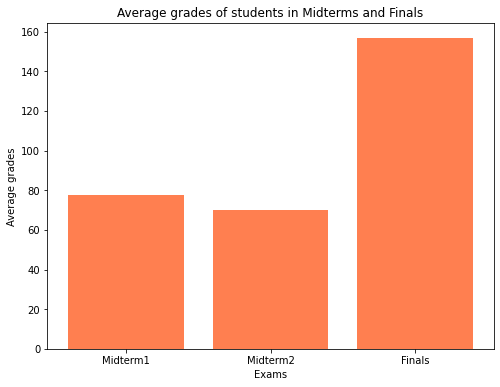

In [309]:
df_grade_copy=df_Grades.copy()

Average_midterm1=df_grade_copy['Midterm 1'].mean()
Average_midterm2=df_grade_copy['Midterm 2'].mean()
Average_finals=df_grade_copy['final'].mean()

data=[['Midterm1',Average_midterm1],['Midterm2',Average_midterm2],['Finals',Average_finals]]
average_grades=pd.DataFrame(data,columns=['Exams','Averages'])
plt.figure(figsize=(8, 6))
plt.bar(average_grades['Exams'],average_grades['Averages'] ,color='coral')
plt.xlabel('Exams')
plt.ylabel('Average grades')
plt.title('Average grades of students in Midterms and Finals')
plt.show()

<div class="alert alert-block alert-warning">
<b>Q10 :</b>Which students basal body temperature was highest during the second part of the exam?
</div>

In [361]:
df_temp_copy=df_Temp.copy()
df_temp_copy['time bin']=df_temp_copy.groupby(['Exam','Student_id'])['Time in mins'].transform(lambda x: pd.cut(x, 3, labels=['First', 'Second', 'Third']))

df_temp_second=df_temp_copy.loc[df_temp_copy['time bin'] == 'Second']

idx = df_temp_second.groupby('Exam')['TEMP'].transform(max) == df_temp_second['TEMP']
df_temp2=df_temp_second[idx]
df_student_details=pd.merge(df_temp2,df_Demography, on='Student_id')
df_student_details[['Student_id','First Name','Last Name','TEMP','Exam','time bin']]

Student_id First Name Last Name    TEMP       Exam time bin
0        S02       Nora     Jones  36.042      final   Second
1        S02       Nora     Jones  34.186  Midterm 1   Second
2        S02       Nora     Jones  35.134  Midterm 2   Second
3        S02       Nora     Jones  35.134  Midterm 2   Second

<div class="alert alert-block alert-warning">
<b>Q11 :</b>What are the top 3 grades in the final exam? What % of the top 3 grades belonged to males vs females? 
</div>

In [155]:
top3_Grades = df_Grades.nlargest(3, 'final')
df_student_details=pd.merge(top3_Grades,df_Demography, on='Student_id')
df_temp=df_student_details[['Student_id','final','Gender']]
df_gender_count = df_temp.groupby(['Gender']).agg(count=('Gender','count'))

def calculate_Percentage(df):
    total_count=3
    df['Percentage']=(df['count']/total_count)*100
    return df

df_gender_count=calculate_Percentage(df_gender_count.copy())
df_gender_percentage=df_gender_count[['Percentage']]

print(df_gender_percentage)

        Percentage
Gender            
F        66.666667
M        33.333333


<div class="alert alert-block alert-warning">
<b>Q12:</b>phonebook={"john":938477566,"Jack":938377264,"Jill":947662781}  ,find the phone number of Joe
</div>

In [96]:
phonebook={"john":938477566,"Jack":938377264,"Jill":947662781}
key="Joe"
default_value='{} phone number not found'.format(key)
print(phonebook.get(key, default_value))

Joe phone number not found


<div class="alert alert-block alert-warning">
<b>Q13 :</b>How many minutes did the midterm 2 last( on average) for all 10 students
</div>

In [115]:
value='midterm 2'
eda_midterm=df_EDA.query("Exam == @value")
exam_time = eda_midterm.groupby(['Student_id','Exam']).agg(total_time=('Time in mins', 'max'))
Average_midterm2_time=exam_time.agg(Average_examtime=('total_time','mean'))
print(Average_midterm2_time)

                  total_time
Average_examtime       201.4


<div class="alert alert-block alert-warning">
<b>Q14 :</b>Analyze the trend of body temp at the start of the exam. Were body temperatures higher or lower in the first part of the exam. What is the overall trend?
</div>

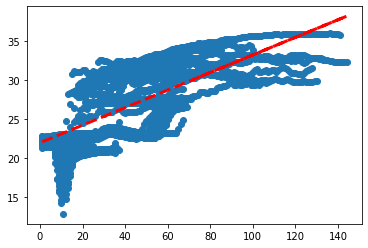

In [354]:
df_temp_first=df_temp_copy.loc[df_temp_copy['time bin'] == 'First']
df_temp_first
# plt.figure(figsize=(8, 6))
plt.scatter(df_temp_first['Time in mins'],df_temp_first['TEMP'])
z = np.polyfit(df_temp_first['Time in mins'],df_temp_first['TEMP'], 1)
p = np.poly1d(z)
plt.plot(df_temp_first['Time in mins'], p(df_temp_first['Time in mins']),color="red", linewidth=3, linestyle="--")
plt.show()

<div class="alert alert-block alert-warning">
<b>Q15 :</b>What % of all students had a HR>80 and an HRV'<'30 in the second part of the finals?
</div>

In [439]:
df_HR_finals=df_HR.copy()


# total_students=df_HR_finals['Student_id'].nunique()

df_grouped_HR=df_HR_finals.groupby(['Exam','Student_id'],dropna=True)


df_grouped_HR=df_grouped_HR.fillna(0)

df_grouped_HR['time bin']=df_grouped_HR['Time in mins'].transform(lambda x: pd.cut(x, 3, labels=['First', 'Second', 'Third']))
print(df_grouped_HR)


#df_hr_second=df_grouped_HR.loc[(df_grouped_HR['time bin'] == 'Second') & (df_grouped_HR['Exam'] == 'Final')]

           HR  Time in mins time bin
0     119.023           1.0    First
1     130.879           2.0    First
2     131.586           3.0    First
3     109.852           4.0    First
4      81.178           5.0    First
...       ...           ...      ...
7369  171.387         214.0   Second
7370  121.597         215.0   Second
7371  109.165         216.0   Second
7372      NaN           NaN      NaN
7373      NaN           NaN      NaN

[7374 rows x 3 columns]


<div class="alert alert-block alert-warning">
<b>Q16 :</b>What was the % difference between scores in both mid-terms vs the final
</div>

In [390]:
df_grades_comparision=df_Grades.copy()
df_grades_comparision['M1vsF']=round((((df_grades_comparision['final']-df_grades_comparision['Midterm 1'])/(df_grades_comparision['final']+df_grades_comparision['Midterm 1']))*100),1).astype(str) + '%'
df_grades_comparision['M2vsF']=round((((df_grades_comparision['final']-df_grades_comparision['Midterm 2'])/(df_grades_comparision['final']+df_grades_comparision['Midterm 2']))*100),1).astype(str) + '%'
df_grades_comparision

Student_id  Midterm 1  Midterm 2  final  M1vsF  M2vsF
0        S01         78         82    182  40.0%  37.9%
1        S02         82         85    180  37.4%  35.8%
2        S03         77         90    188  41.9%  35.3%
3        S04         75         77    149  33.0%  31.9%
4        S05         67         77    157  40.2%  34.2%
5        S06         71         64    175  42.3%  46.4%
6        S07         64         33    110  26.4%  53.8%
7        S08         92         88    184  33.3%  35.3%
8        S09         80         39    126  22.3%  52.7%
9        S10         89         64    116  13.2%  28.9%

<div class="alert alert-block alert-warning">
<b>Q17 :</b>What % of all students are Asian?
</div>

In [132]:
#Defined a function to calculate the percentage
def asian_percentage(students):
    total_students = len(students)
    
    # Count the number of Asian students
    asian_students = students[students['Race'] == 'Asian'].shape[0]
    
    # Calculate the percentage
    asian_percentage = (asian_students / total_students) * 100
    
    return asian_percentage

percentage = asian_percentage(df_Demography)
print(f'The percentage of Asian students is: {percentage:.1f}%')


The percentage of Asian students is: 20.0%


<div class="alert alert-block alert-warning">
<b>Q18 :</b>Display the full name of all students born in 2010
</div>

In [133]:
# Filter and display full names of students born in 2010
born_2010 = df_Demography[df_Demography['DOB'].dt.year == 2010]
full_names = born_2010[['Student_id','First Name','Last Name']]

# Set a custom index
full_names.set_index('Student_id', inplace=True)

# Display the result
print("Full name(s) of students born in 2010:")
print(full_names)


Full name(s) of students born in 2010:
           First Name  Last Name
Student_id                      
S07             Roger  Frederick


<div class="alert alert-block alert-warning">
<b>Q19 :</b>What was the average HR of the students who achieved the top 3 grades in mid-term 2
</div>

In [134]:
mid_term2_grades = df_Grades[['Student_id','Midterm 2']]
heart_rate = df_HR[['Student_id','HR']]

# Group by 'StudentID' and calculate the average 'HR' for each student
average_hr_per_student = heart_rate.groupby('Student_id')['HR'].mean().reset_index()

# Merge the two DataFrames on 'StudentID'
merge_hr_grades = pd.merge(mid_term2_grades, average_hr_per_student, on='Student_id')


# Sort the DataFrame by Midterm2_Grade in descending order
sorted_grades_top3 = merge_hr_grades.sort_values(by='Midterm 2', ascending=False).head(3)

# Set a custom index
sorted_grades_top3.set_index('Student_id', inplace=True)

print("The average HR of the students who achieved the top 3 grades in mid-term 2 :")
print(sorted_grades_top3)

The average HR of the students who achieved the top 3 grades in mid-term 2 :
            Midterm 2          HR
Student_id                       
S03                90  103.283502
S08                88  105.475896
S02                85  114.313813


<div class="alert alert-block alert-warning">
<b>Q20 :</b>Use a bar chart to display the grades of every student in mid term 1
</div>

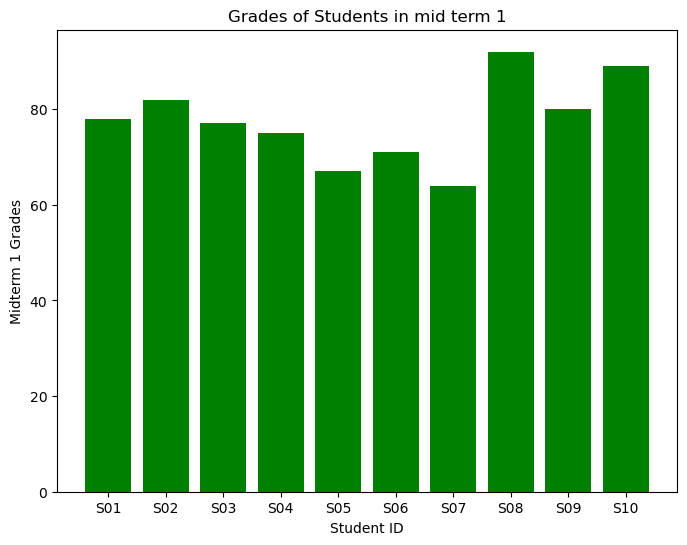

In [5]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(df_Grades['Student_id'], df_Grades['Midterm 1'], color='green')
plt.xlabel('Student ID')
plt.ylabel('Midterm 1 Grades')
plt.title('Grades of Students in mid term 1')
plt.show()

<div class="alert alert-block alert-warning">
<b>Q21 :</b>What % of all students are female?
</div>

In [136]:
#Defined a function to calculate the percentage of female students

def female_percentage(students):
    total_students = len(students)
    
    # Count the number of Asian students
    female_students = students[students['Gender'] == 'F'].shape[0]
    
    # Calculate the percentage
    female_percentage = (female_students / total_students) * 100
    
    return female_percentage

percentage = female_percentage(df_Demography)
print(f'The percentage of Female students is: {percentage:.1f}%')

The percentage of Female students is: 50.0%


<div class="alert alert-block alert-warning">
<b>Q22 :</b>Show the students for whom temperature fell below basal body temp of 36 degrees
</div>

In [137]:
student_temp = df_Temp[['Student_id','TEMP']]

# Group by 'StudentID' and calculate the average Temperature for each student
average_temp_per_student = student_temp.groupby('Student_id')['TEMP'].mean().reset_index()

# Set a custom index
average_temp_per_student.set_index('Student_id', inplace=True)

student_below_36 = average_temp_per_student[average_temp_per_student['TEMP']<36]

print("Students for whom temperature fell below basal body temp of 36 degrees:")
print(student_below_36)

Students for whom temperature fell below basal body temp of 36 degrees:
                 TEMP
Student_id           
S01         26.475624
S010        26.187834
S02         28.224066
S03         26.899314
S04         26.826271
S05         28.553185
S06         27.228459
S07         25.569712
S08         28.464253
S09         28.453486


<div class="alert alert-block alert-warning">
<b>Q23 :</b>Connect to sql and query the data in temp into a table of the same name
</div>

<div class="alert alert-block alert-warning">
<b>Q24 :</b>Display a sunburst chart of count of students by Age, Gender and Race
</div>

In [113]:
import pandas as pd
import plotly.express as px

from datetime import datetime
Demographics = df_Demography

# Convert 'DOB' column to datetime
Demographics['DOB'] = pd.to_datetime(Demographics['DOB'])

# Calculate the age and add it as a new column
current_date = datetime.now()
Demographics['Age'] = (current_date - Demographics['DOB']).astype('<m8[Y]')

# Create a sunburst chart
fig = px.sunburst(Demographics, path=['Age', 'Gender', 'Race'], title='Count of Students by Age, Gender, and Race')

# Show the chart
fig.show()

<div class="alert alert-block alert-warning">
<b>Q25 :</b>Create a visualization on the count of Students with an HRV 10 or more points lower than ideal HRV.
</div>

<div class="alert alert-block alert-warning">
<b>Q26 :</b>Plot a graph to show the distribution of score in the final exam by gender
</div>

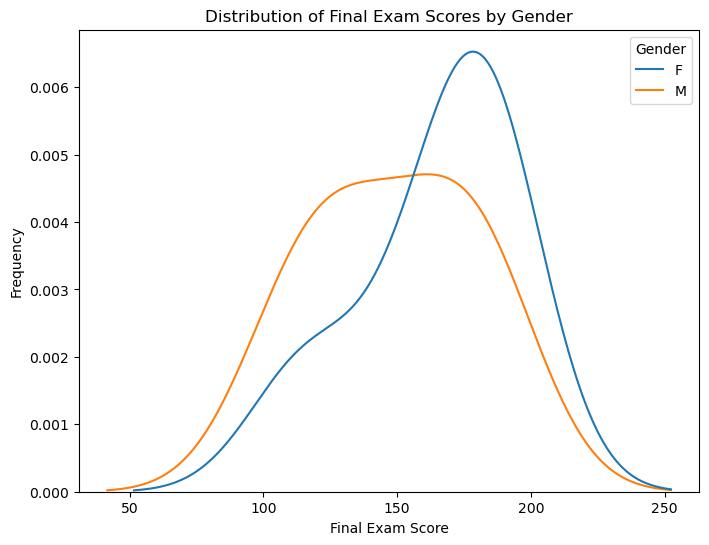

In [140]:
# Merge the two DataFrames on 'StudentID'
merge_demo_grades = pd.merge(df_Grades, df_Demography, on='Student_id')
final_exam_gender =merge_demo_grades[['Student_id','Gender','final']]
# Plot the distribution of scores in the final exam by gender
plt.figure(figsize=(8, 6))
sns.kdeplot(data=final_exam_gender, x="final", hue="Gender")
plt.title('Distribution of Final Exam Scores by Gender')
plt.xlabel('Final Exam Score')
plt.ylabel('Frequency')
plt.show()


<div class="alert alert-block alert-warning">
<b>Q27 :</b>Which demographic has the lowest average of scores in all 3 exams
</div>

In [141]:
# Merge demographics with scores
demo_grade_merge = pd.merge(df_Demography, df_Grades, on='Student_id')
# Calculate average scores for each demographic group
df_averages = demo_grade_merge.groupby(['Gender', 'Race'])['Midterm 1','Midterm 2','final'].mean()

# Find the demographic with the lowest average
lowest_average_demographic = df_averages.mean(axis=1).idxmin()
df_averages['Average Score'] = round(df_averages.mean(axis=1),2)
print("Demographics based analysis on grades:\n")
print(df_averages)

print("\nDemographic with the lowest average scores:\n")
print(lowest_average_demographic)


Demographics based analysis on grades:

                Midterm 1  Midterm 2  final  Average Score
Gender Race                                               
F      African       67.0       77.0  157.0         100.33
       Asian         77.0       90.0  188.0         118.33
       Spanish       89.0       64.0  116.0          89.67
       White         80.0       83.5  181.0         114.83
M      African       67.5       48.5  142.5          86.17
       Asian         75.0       77.0  149.0         100.33
       White         86.0       63.5  155.0         101.50

Demographic with the lowest average scores:

('M', 'African')


<div class="alert alert-block alert-warning">
<b>Q28 :</b>Delete the column age from question 12, using an iterative loop
</div>

In [120]:
Demographics1=Demographics
print("Before Deletion:")
print(Demographics1)
# List of columns to delete
columns_to_delete = ['Age']

# Delete columns using a loop
for column in columns_to_delete:
    if column in Demographics1.columns:
        Demographics1 = Demographics1.drop(column, axis=1)

# Print the DataFrame after deleting the columns
print("After Deletion:")
print(Demographics1)


Before Deletion:
  Student_id        DOB First Name  Last Name Gender     Race   Age
0        S01 2009-01-01    Barbara    Walters      F    White  14.0
1        S02 2009-02-02       Nora      Jones      F    White  14.0
2        S03 2009-07-12    Gabriel    Willows      F    Asian  14.0
3        S04 2009-09-09       John        Doe      M    Asian  14.0
4        S05 2009-05-06       Jane        Doe      F  African  14.0
5        S06 2008-04-04        Pat     Murray      M  African  15.0
6        S07 2010-08-01      Roger  Frederick      M  African  13.0
7        S08 2009-03-03       John      Wills      M    White  14.0
8        S09 2009-10-23       Paul    Cartney      M    White  14.0
9        S10 2009-11-14     Janice      Smith      F  Spanish  14.0
After Deletion:
  Student_id        DOB First Name  Last Name Gender     Race
0        S01 2009-01-01    Barbara    Walters      F    White
1        S02 2009-02-02       Nora      Jones      F    White
2        S03 2009-07-12    Gabrie

<div class="alert alert-block alert-warning">
<b>Q29 :</b>Create a heat map of HRV, temp and scores. To show the correlation beween these variables
</div>

<div class="alert alert-block alert-warning">
<b>Q30 :</b>Use the dataset given and Enumerate in Python with any example.
</div>

In [183]:
# displaying Demographics of eevery female student using enumerate
import pandas as pd

# Enumerate through all rows in the Demographics dataframe
for index, row in df_Demography[df_Demography['Gender'] == 'F'].iterrows():
    #print(f"Index: {index}")
    print("Demographics of Female Students:\n")
    print(row)
    print("_________________________________")

Demographics of Female Students:

Student_id                    S01
DOB           2009-01-01 00:00:00
First Name                Barbara
Last Name                 Walters
Gender                          F
Race                        White
Age                          14.0
Name: 0, dtype: object
_________________________________
Demographics of Female Students:

Student_id                    S02
DOB           2009-02-02 00:00:00
First Name                   Nora
Last Name                   Jones
Gender                          F
Race                        White
Age                          14.0
Name: 1, dtype: object
_________________________________
Demographics of Female Students:

Student_id                    S03
DOB           2009-07-12 00:00:00
First Name                Gabriel
Last Name                 Willows
Gender                          F
Race                        Asian
Age                          14.0
Name: 2, dtype: object
_________________________________
Demographics 

<div class="alert alert-block alert-warning">
<b>Q31 :</b>Create a jointplot on EDA & Grades.
</div>

<Figure size 800x600 with 0 Axes>

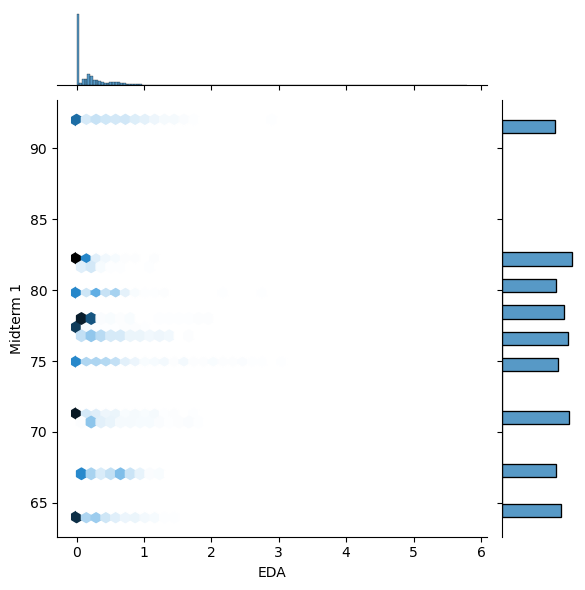

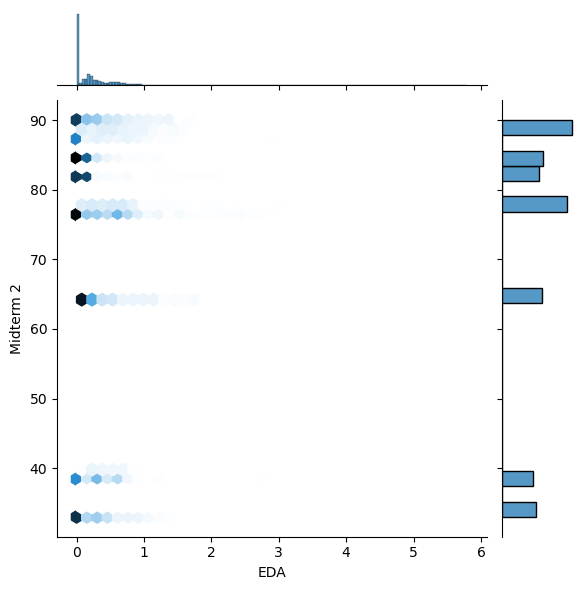

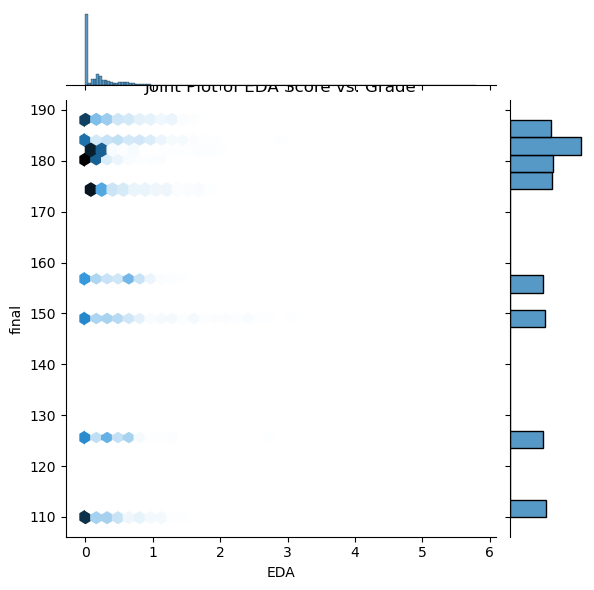

In [143]:

# Merge DataFrames on 'Name'
merged_eda_grades = pd.merge(df_EDA, df_Grades, on='Student_id')
#print(merged_eda_grades)

# Group by 'StudentID' and calculate the average 'HR' for each student
#average_EDA_student = merged_eda_grades.groupby('Student_id')['EDA'].mean().reset_index()
#print(average_EDA_student)

# Create a joint plot
plt.figure(figsize=(8, 6))
sns.jointplot(data=merged_eda_grades, x='EDA', y='Midterm 1', kind='hex')
sns.jointplot(data=merged_eda_grades, x='EDA', y='Midterm 2', kind='hex')
sns.jointplot(data=merged_eda_grades, x='EDA', y='final', kind='hex')
plt.title('Joint Plot of EDA Score vs. Grade')
plt.show()


<div class="alert alert-block alert-warning">
<b>Q32 :</b>Use indexing , loc to retrieve the row with maximum HR
</div>

In [144]:

# Find the index with the maximum value in 'HR' column
max_hr_index = df_HR['HR'].idxmax()

# Use loc to retrieve the row with the maximum HR
row_with_max_hr = df_HR.loc[max_hr_index]

# Display the result
print("Row with maximum HR:")
print(row_with_max_hr)

Row with maximum HR:
HR                199.278
Time in mins         41.0
Student_id            S04
Exam            Midterm 1
Name: 2720, dtype: object


<div class="alert alert-block alert-warning">
<b>Q33 :</b>Make a pivot table where Student IDs are the columns and EDA, HR and temp values are the rows
</div>

In [147]:
heart_rate = df_HR[['Student_id','HR']]
eda=df_EDA[['Student_id','EDA']]
temp=df_Temp[['Student_id','TEMP']]
# Group by 'StudentID' and calculate the average 'HR' for each student
average_hr_per_student = heart_rate.groupby('Student_id')['HR'].mean().reset_index()
average_eda_per_student = eda.groupby('Student_id')['EDA'].mean().reset_index()
average_temp_per_student = temp.groupby('Student_id')['TEMP'].mean().reset_index()

# Merge dataframes on 'Student_id'
merged_df = pd.merge(average_hr_per_student, average_eda_per_student, on='Student_id')
merged_df = pd.merge(merged_df, average_temp_per_student, on='Student_id')


#set index for better presentation
#merged_df.set_index('Student_id', inplace=True)

# Create a pivot table
pivot_table = merged_df.pivot_table(index=['EDA', 'HR', 'TEMP'], columns=['Student_id'])

# Reset index for better presentation
pivot_table = pivot_table.reset_index()
# Print the pivot table
#print(merged_df)
print(pivot_table)


                 EDA          HR       TEMP
Student_id                                 
0           0.111534  114.313813  28.224066
1           0.149369  106.231091  26.187834
2           0.161171  106.522138  26.475624
3           0.208034  103.842102  25.569712
4           0.256905  104.793488  27.228459
5           0.272532  103.283502  26.899314
6           0.299416   98.802752  28.453486
7           0.370783  104.806015  28.553185
8           0.393437  105.475896  28.464253
9           0.464468   98.399456  26.826271


<div class="alert alert-block alert-warning">
<b>Q34 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q35 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q36 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q37 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q38 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q39 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q40 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q41 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q42 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q43
    :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q44 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q45 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q46 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q47 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q49 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q50 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q51 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q52 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q53 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q54 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q55 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q56 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q57 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q58 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q59 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q60 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q61 :</b>Create a dataframe with Max EDA and Mean HR as the indices and the count of number of records per student as the value
</div>

In [482]:

df_eda_records=df_EDA.groupby('Student_id').size().reset_index(name='EDA_count')
df_IBI_records=df_IBI.groupby('Student_id').size().reset_index(name='IBI_count')
df_temp_records=df_Temp.groupby('Student_id').size().reset_index(name='Temp_count')
df_HR_records=df_HR.groupby('Student_id').size().reset_index(name='HR_count')

df_eda_hr_records=pd.merge(df_eda_records,df_HR_records, on='Student_id')
df_ibi_temp_records=pd.merge(df_IBI_records,df_temp_records,on='Student_id')

df_records=pd.merge(df_eda_hr_records,df_ibi_temp_records,on='Student_id')

df_records['total_records']=df_records['EDA_count']+df_records['HR_count']+df_records['IBI_count']+df_records['Temp_count']

df_max_eda=df_EDA.groupby('Student_id')['EDA'].max().reset_index(name='EDA_max')
df_mean_hr=df_HR.groupby('Student_id')['HR'].mean().reset_index(name='HR_mean')


df_records_final=pd.merge(df_max_eda,df_mean_hr, on='Student_id')
df_records_final=pd.merge(df_records_final,df_records, on='Student_id')
df_records_final[['Student_id','EDA_max','HR_mean','total_records']]




df_records_final.set_index(['EDA_max','HR_mean'])

Student_id  EDA_count  HR_count  IBI_count  Temp_count  \
EDA_max HR_mean                                                             
2.198   106.522138        S01        760       760        382         760   
1.423   106.231091       S010        794       794        390         794   
1.311   114.313813        S02        852       852        449         852   
1.651   103.283502        S03        803       803        265         803   
5.795   98.399456         S04        682       682        277         682   
1.611   104.806015        S05        654       653        388         654   
2.184   104.793488        S06        819       819        389         819   
1.485   103.842102        S07        713       713        255         713   
2.920   105.475896        S08        643       642        149         643   
2.756   98.802752         S09        654       654        371         654   

                    total_records  
EDA_max HR_mean                    
2.198   106.522138           2662  
1.423   106.231091           2772  
1.311   114.313813           3005  
1.651   103.283502           2674  
5.795   98.399456            2323  
1.611   104.806015           2349  
2.184   104.793488           2846  
1.485   103.842102           2394  
2.920   105.475896           2077  
2.756   98.802752            2333

<div class="alert alert-block alert-warning">
<b>Q62 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q63 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q64 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q65 :</b>Generate a 3x3 Array using Random values between 1to 9 and Fix the values and position in Next Run.

</div>

In [5]:
np.random.seed(42)
array = np.random.randint(1,9,size=(3,3))
print(array)

[[7 4 5]
 [7 3 8]
 [5 5 7]]


<div class="alert alert-block alert-warning">
<b>Q66 :</b>Find the way to reverse string for given input (eg: input:this is python hackathon output:hackathon python is this
</div>

In [6]:
string = "this is python hackathon"
s=string.split()[::-1]
l=[]
for i in s:
    l.append(i)
    print(" ".join(l))


hackathon
hackathon python
hackathon python is
hackathon python is this


<div class="alert alert-block alert-warning">
<b>Q67 :</b> From 'Python Hackthon Dec 2023' give'Python Hack'using RegEX

</div>

In [7]:
i='Python Hackthon Dec2023'
s= r'Python Hack'
g=re.search(s,i)
if g:
    print(s)

Python Hack


<div class="alert alert-block alert-warning">
<b>Q68 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q69 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q70 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q71 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q72 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q73 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q74 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q75 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q76 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q77 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q78 :</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q78:</b>
</div>

<div class="alert alert-block alert-warning">
<b>Q80 :</b>
</div>

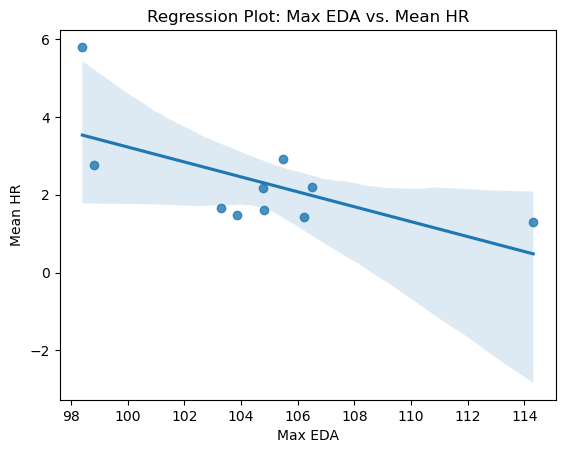

In [169]:
# Merge the two DataFrames on 'StudentID'

mean_hr= df_HR.groupby('Student_id')['HR'].mean()
max_eda= df_EDA.groupby('Student_id')['EDA'].max()
merge_eda_hr = pd.merge(hr,eda, on='Student_id')

# Create a regression plot
sns.regplot(x='HR', y='EDA', data=merge_eda_hr)

# Add labels and title
plt.xlabel('Max EDA')
plt.ylabel('Mean HR')
plt.title('Regression Plot: Max EDA vs. Mean HR')

# Show the plot
plt.show()


# Reference


- [x] __[Markdown Cheatsheet](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet)__
- [x] __[A Wearable Exam Stress Dataset for Predicting Cognitive Performance in Real-World Settings](https://physionet.org/content/wearable-exam-stress/1.0.0/)__
- [x] __[Seaborn](https://seaborn.pydata.org/tutorial.html)__
- [x] __[plotly](https://plotly.com/)__
